<a href="https://colab.research.google.com/github/inteligenciafrvm/inteligenciafrvm/blob/master/Clases%20pr%C3%A1cticas/8.%20Intro%20a%20redes%20neuronales%20con%20Pytorch%20II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción a las Redes Neuronales con Pytorch (Parte II)

* Introducción a Redes neuronales convolucionales (CNN) en Pytorch
* CNNs en CIFAR-10
* Transfer learning con CNNs
 * Uso de redes pre-entrenadas como extractores de features.
 * Fine-tuning para adaptarse a nuestro problema.


5to año - Ingeniería en Sistemas de Información

UTN - Facultad Regional Villa María

Parte de este notebook está basado en material del curso de Aprendizaje Automático y Visión por Computadoras dictado en FaMAF, UNC por Jorge A. Sánchez, en material del curso CS231 de Stanford como https://cs231n.github.io/convolutional-networks/, y en tutoriales de pytorch https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html y https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html.


### 1. Introducción a Redes neuronales convolucionales (CNN) en Pytorch

Vemos a continuación cómo podemos implementar redes neuronales convolucionales en Pytorch. Las redes convolucionales, a diferencia de las NNs que vimos en el pasado notebook, *asumen que la entrada es una imagen*, extendiendo las redes multicapa (MLP) con un conjunto de capas que buscan extraer automáticamente features de dichas imágenes. Esta extracción automática de features es lo que le confiere la potencia a las redes neuronales en dominios como visión, texto y voz.

* Las neuronas de las capas convolucionales tienen 3 dimensiones: ancho, alto y profundidad. Cada capa convolucional consiste en un filtro que la conectan con una pequeña sección del ancho y alto de la imagen de entrada, en lugar de conectarse con todas las neuronas como pasa con MLP. Esto reduce considerablemente la cantidad de conexiones, y lo hace todavía más si los pesos de cada nivel de profundidad del filtro se comparte para todo el alto y ancho de la imagen.

* Las NNs por tanto comúnmente presentan su arquitectura dividida en dos partes: parte "*deep*" conformada por capas convolucionales, y la parte "*fully-connected*" (FC) que es lo que vimos en el notebook pasado. Para conectar ambas, se "aplana" la salida de la última capa convolucional a un vector de 1D.


Repaso rápido:


* Redes neuronales convolucionales (CNN): muy simplificadamente, la operación de convolución en una imagen le aplica un filtro de convolución a la misma en cada posición de sus pixels, para cada uno de sus canales (ejemplo: Red-Green-Blue, RGB). El objetivo de las redes convolucionales es aprender los pesos de tales filtros que mejor extraen los features de imágenes, por ejemplo aprendiendo a detectar sus bordes.
  
  Híper-parámetros (de cada capa convolucional):
   * Número de filtros $C_{out}$: el número de filtros de salida es un híper-parámetro, que determina la cantidad de 
   * Tamaño del filtro (filter size/receptive field) $F$: tamaño del filtro que aplica la convolución a los pixels de la imagen.
   * Stride $S$: determina el deslizamiento del filtro. $S=1$ significa que el filtro se mueve de a un pixel a la vez, de a dos pixels a la vez con $S=2$, etc.
   * Padding $P$: el padding define la magnitud del área fuera de la imagen por donde puede pasar el filtro. 
       
       
  Entrada: Imagen $W_{in} \times H_{in} \times C_{in}$
  
  Salida: Imagen $W_{out} \times H_{out} \times C_{out}$ donde $$W_{out} = (W_{in}-F+2P)/S+1 $$ $$ H_{out} = (H_{out}-F+2P)/S+1 $$  $$C_{out}$$


Importante: al definir nuestras arquitecturas, recordar que esta operación así como el pooling, requieren que en todo momento que los híper-parámetros $F, S, P$ así como el volumen de las imágenes $W, H, C$ tanto de entrada como de salida sean en todo momento números enteros. De no ser así arroja error .

* Pooling: la operación de pooling realiza una reducción (*downsampling*) del ancho y largo de la imagen, reduciendo así la cantidad de parámetros de la arquitectura y sucesivos cálculos (que es la principal razón por la que se la utiliza).

    Híper-parámetros:
    * Tamaño del filtro $F$
    * Stride $S$
    * Criterio de pooling: normalmente se suele usar el criterio de *max pooling* (es decir tomar el valor máximo del filtro de pooling de $F \times F$), pero también puede usarse otro como *average pooling*.
    
    Entrada: Imagen $W_{in} \times H_{in} \times C$
    
    Salida: Imagen $W_{out} \times H_{out} \times C$ donde $$W_{out} = (W_{in}-F)/S+1 $$ $$ H_{out} = (H_{out}-F)/S+1 $$  $$C$$

* Cross-entropy loss: la función de costo de entropía cruzada para cada imagen dado el índice de la salida correcta $i$, está dada por $$L_i = -log \left(\frac{e^{f_i}}{\sum_j e^{f_j}} \right) = -f_{i} + log\left(\sum_j e^{f_j}\right)$$ donde $$\frac{e^{x_i}}{\sum_j e^{x_j}}$$ es la función *Softmax*, que convierte un array, en este caso las salidas lineales de la red definida varias celdas debajo, en probabilidades. La pérdida total por cada minibatch es el promedio de todas las pérdidas de todas las imágenes del mismo.

    Veamos un ejemplo...

 

In [1]:
import numpy as np

f_10_clases = np.array([-0.3377, 
                        -0.7665,  
                         0.5616,  
                         0.8967,  
                         0.1177,  
                         0.2450,  
                         1.9977, 
                        -1.2577, 
                        -0.9191, 
                        -1.2244])

# aplicamos la función e a cada una
f_10_clases_exp = np.exp(f_10_clases)
print(f_10_clases_exp)

[0.71340928 0.46463645 1.75347582 2.4514998  1.12490659 1.27762131
 7.3720808  0.28430718 0.39887787 0.29393401]


In [2]:
# transformamos estas clases en probabilidades...
f_10_clases_prob = f_10_clases_exp / np.sum(f_10_clases_exp)
print(f_10_clases_prob)
print(np.sum(f_10_clases_prob))

[0.0442157  0.02879725 0.10867698 0.15193913 0.0697195  0.07918445
 0.45690706 0.0176208  0.02472167 0.01821745]
1.0


In [3]:
# supongamos que la clase correcta era i=2, la pérdida por entropía cruzada sería:
print(-np.log(f_10_clases_prob[2]))

2.2193752758952074


Minimizar esta función equivale a maximizar la probabilidad de la clase correcta (y, por lo tanto, a minimizar la probabilidad de las demás).

Muy buena forma de visualizar las NNs https://poloclub.github.io/cnn-explainer/

### 2. CNNs en CIFAR-10

Para el siguiente ejemplo vamos a utilizar el dataset de imágenes [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html). El mismo consiste en 60.000 imágenes de 32x32 (x3 canales RGB), con 10 clases mutuamente excluyentes (6.000 imágenes por clase), de las cuales 50.000 son de entrenamiento y 10.000 de test.

Las imágenes de este ejemplo están normalizadas entre $[0,1]$, en donde 0 para un canal R, G o B se corresponde con un valor 0 de intensidad en el pixel, y 1 se corresponde con el valor 255 de intensidad.

![CIFAR10](images/8/cifar10.png)

Fuente: Alex Krizhevsky en https://www.cs.toronto.edu/~kriz/cifar.html

**IMPORTANTE!** Para correr localmente el código que sigue se necesita instalar los paquetes de Pytorch para su uso en CPU (es decir sin Cuda) o bien contar con una GPU Nvidia con CUDA $\geq$ 9. De lo contrario al importar torchvision va a arrojar un error de importación de *libcudart.so.9.0*.

También se puede correr este notebook con la GPU compartida de Google Colab desde el link de la primera celda, y habilitando la GPU en Colab desde *Edit -> Notebook settings -> Hardware accelerator -> cambiando None por GPU*.

In [4]:
# importamos

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline

A continuación mediante las transformaciones de torchvision realizamos una serie de operaciones a las imágenes de todo el dataset. Las transformaciones pueden verse en https://pytorch.org/docs/stable/torchvision/transforms.html. En este caso se realiza una normalización de media y desviación estándar a 0.5 en cada canal, un tipo de normalización común para pre-procesar las imágenes de modo que los valores de entrada de las mismas caigan siempre en un rango determinado.

En este caso, normalizar con medias y desviaciones estándar en $(0.5, 0.5, 0.5)$ hará que los valores de entrada establecidos en $[0,1]$ caigan en rangos $[-1,1]$, lo que resulta mejor para trabajarlos con redes neuronales.

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# descargamos CIFAR10 (train)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform) 
# creamos un dataloader para recorrerlo
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

# hacemos lo mismo con el conjunto de test
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Veamos algunas de las imágenes de entrenamiento

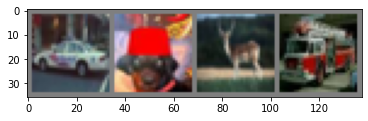

  car   dog  deer truck
Primera imagen como tensor normalizado: 
 tensor([[[-0.3725, -0.4039, -0.3725,  ..., -0.3255, -0.0118,  0.3255],
         [-0.2314, -0.3490, -0.2706,  ..., -0.3882, -0.3490, -0.0824],
         [-0.3098, -0.3098, -0.2314,  ..., -0.3882, -0.4667, -0.3255],
         ...,
         [-0.5294, -0.5373, -0.5294,  ...,  0.3255, -0.1686, -0.5529],
         [-0.5216, -0.5216, -0.5137,  ...,  0.2863, -0.3882, -0.5608],
         [-0.5294, -0.5137, -0.5059,  ...,  0.0510, -0.5216, -0.5451]],

        [[-0.5922, -0.7412, -0.7412,  ..., -0.2471,  0.0353,  0.3333],
         [-0.4980, -0.7804, -0.7804,  ..., -0.3098, -0.2863, -0.0510],
         [-0.6000, -0.7804, -0.8039,  ..., -0.3176, -0.4039, -0.3098],
         ...,
         [-0.4588, -0.4353, -0.4039,  ...,  0.4588,  0.0196, -0.3412],
         [-0.4431, -0.4275, -0.3961,  ...,  0.4431, -0.1843, -0.3255],
         [-0.4275, -0.4039, -0.3804,  ...,  0.2235, -0.3255, -0.3333]],

        [[-0.6078, -0.7098, -0.7020,  ..., -0.2549

In [6]:
from utils import imshow

# obtenemos aleatoriamente algunas imágenes de entrenamiento
dataiter = iter(trainloader)
images, labels = dataiter.next()

# mostramos dichas imágenes y sus categorías
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

print('Primera imagen como tensor normalizado: \n {}'.format(images[0]))

Definimos ahora nuestra red convolucional. La misma va a tener la siguiente arquitectura:

* Entrada: imagen 32x32x3
* Capa conv1 con kernel=5 (es decir 5x5), stride=1, c_out=6, activación ReLU. Entrada: imagen 32x32x3 -> salida: volumen 28x28x6
* Pooling con k=2, s=2. Entrada: 28x28x6 -> salida : volumen 14x14x6
* Capa conv2 con k=5, s=1, c=16, activación ReLU. Entrada 14x14x6 -> salida: volumen 10x10x16
* Pooling con k=2, s=2. Entrada 10x10x16 -> salida: volumen 5x5x16
* Aplanada a vector de 16\*5\*5 = 400 features de entrada.
* Capa lineal1. Entrada: 400, salida 120. Sin activación.
* Capa lineal2. Entrada: 120, salida 84. Sin activación.
* Capa lineal3. Entrada: 84, salida 10 (una por cada clase de imagen). Sin activación.

In [7]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
    
        # interfaz de nn.Conv2d:
        # nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0) 
        self.conv1 = nn.Conv2d(3, 6, 5)
        # nn.MaxPool2d(kernel_size, stride=None, padding=0)
        self.pool = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # 16 canales de salida * 5 alto de la imagen * 5 ancho de la imagen
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Definimos una función de loss (cross entropy) y un optimizador (SGD) con momentum (al actualizar el gradiente se incluye una porción de la actualización del gradiente anterior)

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Entrenamos nuestra red convolucional como lo veníamos haciendo

In [9]:
for epoch in range(2):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # obtiene las entradas
        inputs, labels = data

        # limpia los gradientes
        optimizer.zero_grad()

        # forward + backward + optimización
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # muestra estadísticas
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] training loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] training loss: 2.179
[1,  4000] training loss: 1.822
[1,  6000] training loss: 1.649
[1,  8000] training loss: 1.536
[1, 10000] training loss: 1.508
[1, 12000] training loss: 1.455
[2,  2000] training loss: 1.405
[2,  4000] training loss: 1.360
[2,  6000] training loss: 1.334
[2,  8000] training loss: 1.322
[2, 10000] training loss: 1.274
[2, 12000] training loss: 1.272
Finished Training


Vemos algunas predicciones del conjunto de test para ver cómo está aprendiendo a generalizar. Primero, tomamos una pequeña muestra de imágenes del mismo

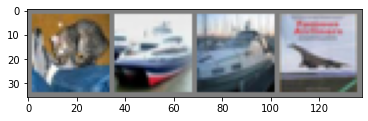

Clases verdaderas:    cat  ship  ship plane


In [10]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# mostramos las imágenes
imshow(torchvision.utils.make_grid(images))
print('Clases verdaderas: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Veamos cuál es la "energía" que nuestro clasificador le asigna a cada una de las imágenes de nuestra muestra. A mayor energía, más la red "piensa" que la imagen pertenece a una clase determinada.

In [11]:
with torch.no_grad():
    outputs = net(images)
    print(outputs)

tensor([[-0.9864, -1.8086,  0.1888,  2.1274, -0.3862,  1.5898,  1.1028, -0.2759,
         -0.7025, -1.2971],
        [ 4.5099,  4.3268, -1.9146, -3.8116, -2.5309, -5.6470, -3.8035, -4.1495,
          6.7060,  3.1773],
        [ 2.8146,  2.7154, -0.8876, -1.7717, -1.8032, -2.7103, -3.0152, -1.4495,
          2.9465,  2.4285],
        [ 5.0630,  0.1246,  1.4679, -2.4712,  1.4514, -3.8610, -2.6994, -2.5765,
          3.5381, -0.6493]])


Veamos los índices para las mayores energías de cada clase...

In [12]:
with torch.no_grad():
    _, predicted = torch.max(outputs, 1)

    print('Clases estimadas: ', ' '.join('%5s' % classes[predicted[j]]
                                  for j in range(4)))

Clases estimadas:    cat  ship  ship plane


Veamos cómo rindió nuestra red para todo el conjunto de test

In [13]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Tasa de acierdos de la red para las 10000 imágenes de test: %d %%' % (
    100 * correct / total))

Tasa de acierdos de la red para las 10000 imágenes de test: 55 %


Teniendo en cuenta que la tasa de aciertos para un clasificador aleatorio es del 10%, el porcentaje obtenido está muy bien para empezar. A modo de comparación, ~94% es la tasa de aciertos de un humano para CIFAR-10.

Veamos la tasa de aciertos por cada clase...

In [14]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Tasa de aciertos para la clase %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Tasa de aciertos para la clase plane : 64 %
Tasa de aciertos para la clase   car : 66 %
Tasa de aciertos para la clase  bird : 29 %
Tasa de aciertos para la clase   cat : 20 %
Tasa de aciertos para la clase  deer : 40 %
Tasa de aciertos para la clase   dog : 46 %
Tasa de aciertos para la clase  frog : 82 %
Tasa de aciertos para la clase horse : 63 %
Tasa de aciertos para la clase  ship : 79 %
Tasa de aciertos para la clase truck : 58 %


¿Se te ocurre cómo mejorar el desempeño de la red? Inténtalo!

### 3. Transfer learning con CNNs


* Hasta aquí hemos visto el entrenamiento de una muy pequeña NN para un dataset de imágenes pequeñas.
* No obstante, en el estado del arte hay datasets mucho más grandes. Por ejemplo, [ImageNet](http://image-net.org/about-stats)...
  * ... tiene más de 14 millones de imágenes anotadas a mano (~150 Gb de tamaño total del dataset) con una resolución promedio de 469x387 pixels.
  * Cada imagen pertenece a una de las 27 categorías de alto nivel (ej: "animal") que a su vez tienen más de 20.000 subcategorías específicas de acuerdo a la clasificación de WordNet (ej: "invertebrate" tiene subcategoría "arthropod" que a su vez tiene a "arachnid").



* Para entrenar una NN de buen tamaño sobre un dataset de esa magnitud, se requiere una buena cantidad de recursos. Es por eso que en la práctica normalmente no se entrena una CNN sobre un gran dataset desde 0 (excepto que se cuente con recursos de hardware o cómputo en la nube suficientes), sino que se realiza *transfer-learning*: usar una arquitectura con sus pesos pre-entrenados y adaptarla a nuestro problema.
* Pytorch cuenta con modelos de clasificación pre-entrenados (todos sobre ImageNet), que pueden verse [aquí](https://pytorch.org/docs/stable/torchvision/models.html#classification), en donde se referencia el paper de cada modelo. Los modelos pre-entrenados tienen que normalizarse (según el canal RGB) con valores mean = [0.485, 0.456, 0.406] y std = [0.229, 0.224, 0.225], que son las medias y desviaciones estandar de todo ImageNet (también se suelen rescalar todas las imágenes en 256x256 para tratarlas de forma homogénea).

En esta parte, vamos a ver dos alternativas de transfer-learning. Usaremos una red con pesos pre-entrenados para un dominio (ImageNet) parecido a uno de nuestro interés (distinguir hormigas de abejas), congelando sus parámetros (es decir dejarlos fijos, cesando su optimización), y descartando la última capa FC que estaba asociada a las salidas de ImageNet. Abordaremos dos formas de transferencia de aprendizaje:

1. Extracción de features: Se usará la red pre-entrenada para la extracción de features, usando esos features como entrada para entrenar un modelo tradicional como KNN o SVM.
1. Fine-tuning: Se dejarán descongeladas una o dos capas del final de la red, con las que reanudaremos su optimización para adaptarse a nuestro problema.

Como ejemplo ilustrativo, vamos a realizar fine-tuning para entrenar a nuestro clasificador de insectos hymenópteros (en nuestro caso dos clases: abejas y hormigas). Las imágenes se pueden descargar manualmente desde [aquí](https://download.pytorch.org/tutorial/hymenoptera_data.zip) (eso se realiza automáticamente en la celda siguiente, si no funciona, descargar desde el link y extraer el zip en ./data/hymenoptera_data).

#### Alternativa 1: uso de redes pre-entrenadas como extractores de features

In [15]:
# descargamos y extraemos los archivos (fuente: https://discuss.pytorch.org/t/how-does-one-download-a-data-set-from-a-file-automatically-with-pytorch/74262)
# (requiere ipywidgets, que se instala mediante conda install -c conda-forge ipywidgets o pip3 install ipywidgets --user sin conda)

from torchvision.datasets.utils import download_and_extract_archive
import os

if not os.path.exists("./data/hymenoptera_data"):

    url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
    root = './data/'

    download_and_extract_archive(url, root)
    print("Archivos descargados y extraidos con éxito")
    
else:
    print("La carpeta ya existe")

La carpeta ya existe


Definimos importaciones, variables iniciales y transformaciones que aplicaremos a cada imagen

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import os

from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision import transforms
from torch.utils.data import DataLoader
from utils import imshow_tensor

path = './data/hymenoptera_data/'

batch_size = 4
num_workers = 2

# transformaciones que se aplicarán sobre cada imagen:
#   1. el lado más chico de la imagen a 256 pixels manteniendo relación de aspecto (PIL -> PIL)
#   2. crop de la región central de 224x224 pixels (PIL -> PIL)
#   1. transformar la imagen PIL a un tensor de pytorch (PIL -> Tensor)
#   2. aplicar la normalización (estandarización) con la que fueron entrenados los modelos en torchvision  (Tensor -> Tensor)
transform = transforms.Compose([    
    transforms.Resize(256),    
    transforms.CenterCrop(224),   
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Definimos el dataset y visualizamos algunas imágenes

torch.Size([4, 3, 224, 224])
tensor([1, 1, 1, 1])
['bees', 'bees', 'bees', 'bees']


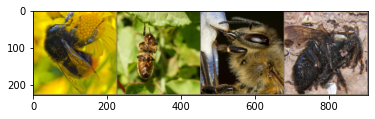

In [17]:
# dataset
data = ImageFolder(os.path.join(path, 'train'), transform)

# data loader
loader = DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

image_batch, labels = next(iter(loader))
print(image_batch.size())
print(labels)
print([data.classes[lbl] for lbl in labels])
grid = make_grid(image_batch)
imshow_tensor(grid)
  

Para utilizar una red pre-entrenada para la extracción de features, debemos limitarla a lo que nos interesa. En nuestro caso emplearemos la red ResNet, donde utilizaremos la salida de la penúltima capa como representación de la imagen.

In [18]:
import torch
from torch import nn
from torchvision import models
from tqdm import tqdm_notebook as progressbar

class FeatureExtractor(nn.Module):
    def __init__(self):        
        super().__init__()
        # leer red pre-entrenada
        model = models.resnet18(pretrained=True)
        
        # congelamos los parámetros
        for p in model.parameters():
            p.requires_grad_(False)
            
        # armamos modelo secuencial que incluya todas las capas salvo la última (fc)
        layers = list(model.children())[:-1] # quitamos la última capa
        self.net = nn.Sequential(*layers) 
        
    def forward(self, x):        
        N = x.size(0)  # batch size
        x = self.net(x)
        return x.view(N, -1) # redimensionamos la salida para adaptarla a nuestro modelo

Creamos nuestra función de extracción de features. La misma toma como entrada el nombre del subconjunto (train o val), carga y transforma el dataset, y devuelve los features X extraídos con el método anterior y sus respectivas etiquetas.

In [19]:
def features_and_labels(set_):
    if set_ not in ('train', 'val'):
        raise ValueError('not a valid data set')
        
    transform = transforms.Compose([    
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    data = ImageFolder(os.path.join(path, set_), transform)
    
    loader = DataLoader(data, batch_size=1, shuffle=False, num_workers=0)
    
    extractor = FeatureExtractor()
    # extractor = extractor.to(device)
    extractor.eval()
    
    features, labels = [], []
    
    for img, lbl in progressbar(loader):
        # img = img.to(device)
        feat = extractor(img)    
        # feat = feat.cpu()
        features.append(feat)
        labels.append(lbl)

    features = torch.cat(features, dim=0)
    labels = torch.cat(labels, dim=0)
    
    return features, labels


Extraemos los features de la salida

In [20]:
train_features, train_labels = features_and_labels('train')
val_features, val_labels = features_and_labels('val')
print(train_features.size(), val_features.size())


torch.Size([244, 512]) torch.Size([153, 512])


Dividimos los features en entrenamiento y test, para usarlos como entrada de un modelo de scikit learn

In [21]:
x_train, y_train = train_features.cpu().numpy(), train_labels.cpu().numpy().reshape(-1, 1)
x_test, y_test = val_features.cpu().numpy(), val_labels.cpu().numpy().reshape(-1, 1)

# # para evitar recomputar los features cada vez, se pueden almacenar a disco 
# np.save("resnet18.npy", {'x_train': x_train, 'y_train': y_train, 'x_test': x_test, 'y_test': y_test}, allow_pickle=True)
# mydata = np.load("resnet18.npy", allow_pickle=True)
# x_train = mydata.item().get('x_train')
# y_train = mydata.item().get('y_train')
# x_test = mydata.item().get('x_test')
# y_test = mydata.item().get('y_test')

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# agrega tu código aquí para realizar una clasificación con modelos de sklearn

(244, 512) (244, 1)
(153, 512) (153, 1)


#### Alternativa 2: ajuste fino (fine-tuning)

En esta parte adaptaremos un modelo pre-entrenado para clasificar sobre ImageNet a nuestro problema de clasificación de hormigas y abejas. La idea es la siguiente: tomamos un modelo preentrenado y reemplazamos la última capa (la que define el número de salidas de la red, p.ej, 1000 categorías de ImageNet) con una que se adapte a nuestro problema.

Si el número de datos de entrenamiento disponibles para el nuevo problema es chico, adaptaremos únicamente ésta última capa de la red. Si éste número es mayor, podemos adaptar más capas (en general, desde la salida hacia la entrada). La forma de seleccionar que parámetros (capas) adaptaremos y cuáles no, es seteando el atributo ```requieres_grad``` de cada nodo al valor deseado. 

Únicamente aquellos nodos que tengan éste atributo en ```True``` serán adaptados durante el proceso de optimización. A continuación exploraremos esta idea mediante la definición de un modelo adaptado al problema de abejas y hormigas (2 clases).

In [22]:
# se carga modelo preentrenado
model = models.resnet18(pretrained=True)

# se congelan todos los parámetros
for p in model.parameters():
    p.requires_grad_(False)

# reemplazamos la última capa lineal por una nueva adaptada a nuestro problema. 
# En el caso de los modelos resnet en pytorch, la última capa lineal corresponde al miembro .fc 
# (para ver la red en detalle hacer print(model))
in_features = model.fc.in_features  # se toma la cantidad de features de salida de la capa fc de resnet
num_classes = 2
model.fc = nn.Linear(in_features, num_classes)  # y se reemplaza la capa por una nueva capa lineal nuestra

# se guardan la lista de parámetros a actualizar que pasaremos al optimizador
parameters_to_update = [p for p in model.parameters() if p.requires_grad]

Con el modelo definido, resta armar el resto de la estructura de entrenamiento (data loaders, funciones de costo y optimización)

In [23]:
batch_size = 32
num_workers = 4

# data transforms 
data_transform = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),  # data augmentation!
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [24]:
# dataset splits
data = {
    'train': ImageFolder(os.path.join(path, 'train'), data_transform['train']),
    'val': ImageFolder(os.path.join(path, 'val'), data_transform['val'])
}    

# dataloaders
data_loader = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=False, num_workers=num_workers)
}

# criterio de optimización
criterion = nn.CrossEntropyLoss()

# Optimizador
optimizer = torch.optim.Adam(parameters_to_update, lr=1.0)

Definimos funciones de entrenamiento y validación de nuestro modelo

In [25]:
def train(model, data_loader, criterion, optimizer, device):            
    model.train()
    running_loss = 0.
    running_acc = 0.
       
    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
                
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
           
        _, preds = torch.max(outputs, 1)
        
        running_loss += loss.item() * inputs.size(0)
        running_acc += torch.sum(preds == labels.data)
                
    running_loss /= len(data_loader.dataset)
    running_acc /= len(data_loader.dataset)
                
    return running_loss, running_acc                

In [26]:
def validate(model, data_loader, criterion, device):          
    model.eval()
    running_loss = 0.
    running_acc = 0.
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
                        
            outputs = model(inputs)
            loss = criterion(outputs, labels)
           
            _, preds = torch.max(outputs, 1)
        
            running_loss += loss.item() * inputs.size(0)
            running_acc += torch.sum(preds == labels.data)
                
        running_loss /= len(data_loader.dataset)
        running_acc /= len(data_loader.dataset)
                
    return running_loss, running_acc  

Realizamos el entrenamiento

In [27]:
from tqdm import tqdm_notebook as progressbar

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device)

num_epochs = 10

for epoch in progressbar(range(1, num_epochs+1)):
        train_loss, train_acc = train(model, data_loader['train'], criterion, optimizer, device)
        
        val_loss, val_acc = validate(model, data_loader['val'], criterion, device)
        
        print('[{}] loss: train={:.3f}, val={:.3f} -- accuracy: train={:.3f}, val={:.3f}'.format(epoch, train_loss, val_loss, train_acc, val_acc))

[1] loss: train=92.572, val=45.289 -- accuracy: train=0.607, val=0.712
[2] loss: train=39.446, val=9.286 -- accuracy: train=0.758, val=0.922
[3] loss: train=23.598, val=23.703 -- accuracy: train=0.848, val=0.895
[4] loss: train=17.978, val=13.124 -- accuracy: train=0.873, val=0.941
[5] loss: train=13.648, val=20.861 -- accuracy: train=0.898, val=0.902
[6] loss: train=10.217, val=10.664 -- accuracy: train=0.939, val=0.948
[7] loss: train=4.687, val=13.433 -- accuracy: train=0.963, val=0.935
[8] loss: train=2.635, val=12.032 -- accuracy: train=0.980, val=0.948
[9] loss: train=3.815, val=11.514 -- accuracy: train=0.963, val=0.961
[10] loss: train=8.241, val=14.905 -- accuracy: train=0.943, val=0.922



Algunas actividades opcionales para intentar con transfer-learning...

Transfer a modelos de scikit-learn

1. Evaluar clasificadores que vimos anteriormente, como KNN o SVC. Buscar combinaciones de híper-parámetros que mejoren la performance del modelo.

Fine-tuning

1. Con las capas freezadas, encontrar rangos de valores razonables para el learning_rate. Observar evolución de la función de costo ("train" y "val") para guiar la búsqueda y selección.

1. En lugar de dejar capas congeladas, configurar la red para adaptar todos sus parámetros y reentrenar la misma para el nuevo dataset. Evaluar cómo resulta tal entrenamiento.

1. De contar con disponibilidad de GPUs (o desde Google Colab), probar cambiando la arquitectura a una más compleja (ej. resnet50).

General

1. Buscar algún otro dominio de imágenes para hacer transfer-learning. Tener en cuenta que según el formato de pytorch, se deben dividir las imágenes en carpetas train y val, y a su vez cada una de ellas en una subcarpeta por clase.

1. Implementar esquemas de data augmentation más agresivos durante el entrenamiento (p.ej. rotaciones o crops aleatorios, etc.) y evaluar cómo mejora el modelo con ellos. Ver transformaciones disponibles [acá](https://pytorch.org/docs/stable/torchvision/transforms.html).
